In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gini(solution, submission):
    df = zip(solution, submission)
    df = sorted(df, key=lambda x: (x[1],x[0]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    solution=np.array(solution)
    submission=np.array(submission)
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

In [3]:
train_df = pd.read_csv("../data/train.csv", index_col=0)
test_df = pd.read_csv("../data/test.csv", index_col=0)

In [4]:
labels = train_df.Hazard
train_df.drop('Hazard', axis=1, inplace=True)
test_indices = test_df.index

In [5]:
train = np.array(train_df)
test = np.array(test_df)

In [6]:
train

array([[15, 3, 2, ..., 'E', 2, 2],
       [16, 14, 5, ..., 'E', 2, 1],
       [10, 10, 5, ..., 'E', 6, 1],
       ..., 
       [18, 7, 5, ..., 'E', 1, 1],
       [18, 17, 5, ..., 'C', 2, 6],
       [5, 15, 3, ..., 'E', 5, 4]], dtype=object)

In [7]:
# label encode the categorical variables
for i in range(train.shape[1]):
    if type(train[1,i]) is str:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[:,i]) + list(test[:,i]))
        train[:,i] = lbl.transform(train[:,i])
        test[:,i] = lbl.transform(test[:,i])

In [8]:
train = train.astype(float)
test = test.astype(float)

In [9]:
train[0]

array([ 15.,   3.,   2.,   5.,   1.,   0.,   1.,   1.,   2.,   7.,   1.,
         1.,  15.,   1.,   0.,   1.,   0.,  36.,  11.,   0.,  10.,   1.,
         2.,  37.,   1.,  11.,   6.,   1.,   0.,   4.,   2.,   2.])

In [10]:
train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=.2)

In [11]:
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                      max_depth=1, random_state=0, loss='ls').fit(train_x, train_y)
mean_squared_error(test_y, clf.predict(test_x))

predictor_test = clf.predict(test_x)
predictor_train = clf.predict(train_x)

print normalized_gini(train_y, predictor_train)
print normalized_gini(test_y, predictor_test)

0.305269895868
0.296576569174


In [12]:
predictors = clf.predict(test)
preds = pd.DataFrame({"Id": test_indices, "Hazard": predictors})
preds = preds.set_index('Id')
preds.to_csv('../results/gradboosting_regression.csv')

In [13]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print indices

[ 7  1  0  3  8 25 11 14 31 15  2  4 13 10 20  9 29 28  5  6 27 26 22 21 12
 23 30 16 17 18 19 24]


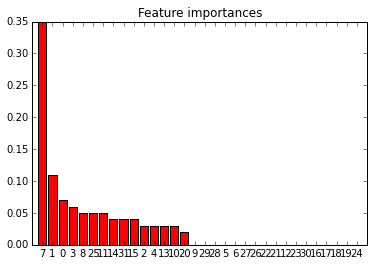

In [14]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(32), importances[indices], color="r", align="center")
plt.xticks(range(32), indices)
plt.xlim([-1, 32])
plt.show()